In [ ]:
!pip install torch torchvision

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader

from torchvision import datasets 
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [ ]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

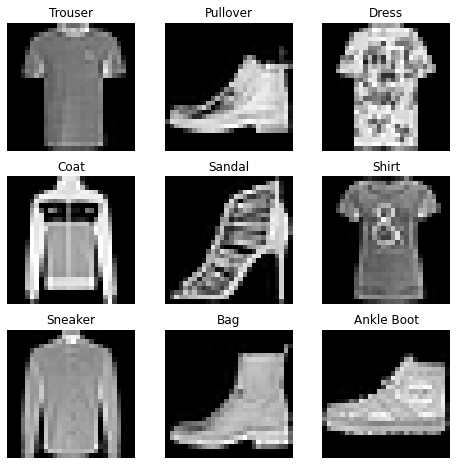

In [5]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

fig = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, len(labels_map)):
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  img, label = training_data[sample_idx]
  fig.add_subplot(rows, cols, i)
  plt.title(labels_map[i])
  plt.axis('off')
  plt.imshow(img.squeeze(), cmap='gray')
plt.show()



In [6]:
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size)
test_dataloader = DataLoader(test_data, batch_size)

In [7]:
random_pair = [(X, y) for X, y in train_dataloader][123]

In [8]:
random_pair[0].shape, random_pair[1].shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [23]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack_of_layers = nn.Sequential(
        nn.Linear(28 * 28, 1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    )

  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack_of_layers(x)
    return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack_of_layers): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [24]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [12]:
# model.train() tells your model that you are training the model. This helps inform layers such as Dropout and BatchNorm, which are designed to behave differently during training and evaluation. For instance, in training mode, BatchNorm updates a moving average on each new batch; whereas, for evaluation mode, these updates are frozen.

# More details: model.train() sets the mode to train (see source code). You can call either model.eval() or model.train(mode=False) to tell that you are testing. It is somewhat intuitive to expect train function to train model but it does not do that. It just sets the mode.

In [14]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  model.train()

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    pred = model(X)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [15]:
def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [25]:
for epoch in range(8):
  print(f'Epoch {epoch+1}\n'+20*'.')
  train(train_dataloader, model, loss_function, optimizer)
  test(test_dataloader, model, loss_function)


Epoch 1
....................
loss: 2.293561  [    0/60000]
loss: 2.297920  [ 6400/60000]
loss: 2.295206  [12800/60000]
loss: 2.301703  [19200/60000]
loss: 2.291600  [25600/60000]
loss: 2.281124  [32000/60000]
loss: 2.290679  [38400/60000]
loss: 2.272823  [44800/60000]
loss: 2.271375  [51200/60000]
loss: 2.281024  [57600/60000]
Test Error: 
 Accuracy: 34.4%, Avg loss: 2.271604 

Epoch 2
....................
loss: 2.261915  [    0/60000]
loss: 2.268001  [ 6400/60000]
loss: 2.257481  [12800/60000]
loss: 2.269404  [19200/60000]
loss: 2.253181  [25600/60000]
loss: 2.236880  [32000/60000]
loss: 2.251219  [38400/60000]
loss: 2.227515  [44800/60000]
loss: 2.226918  [51200/60000]
loss: 2.225990  [57600/60000]
Test Error: 
 Accuracy: 42.2%, Avg loss: 2.218452 

Epoch 3
....................
loss: 2.212301  [    0/60000]
loss: 2.217786  [ 6400/60000]
loss: 2.192754  [12800/60000]
loss: 2.211182  [19200/60000]
loss: 2.179055  [25600/60000]
loss: 2.150270  [32000/60000]
loss: 2.173895  [38400/60000]

In [26]:
torch.save(model.state_dict(), 'model.pth')
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


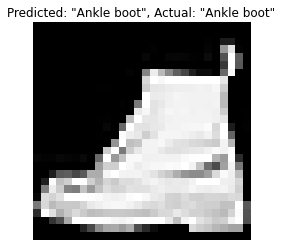

In [44]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()

sample_idx = 2132
x, y = test_data[sample_idx][0], test_data[sample_idx ][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]

plt.title(f'Predicted: "{predicted}", Actual: "{actual}"')
plt.axis('off')
plt.imshow(x.squeeze(), cmap='gray')
plt.show()


Tensors

In [66]:
tensor = torch.randint(10, (4, 5)); tensor

tensor([[2, 6, 8, 5, 7],
        [8, 3, 7, 2, 6],
        [8, 7, 5, 7, 8],
        [0, 5, 9, 0, 4]])

In [71]:
tensor * 2

tensor([[ 4, 12, 16, 10, 14],
        [16,  6, 14,  4, 12],
        [16, 14, 10, 14, 16],
        [ 0, 10, 18,  0,  8]])

In [75]:
t1 = tensor[1:3, :]; t1.T

tensor([[8, 8],
        [3, 7],
        [7, 5],
        [2, 7],
        [6, 8]])

In [76]:
tensor @ t1.T

tensor([[142, 189],
        [162, 182],
        [182, 251],
        [102, 112]])

In [81]:
tensor.matmul(t1.T).numpy()

array([[142, 189],
       [162, 182],
       [182, 251],
       [102, 112]])